## Plot Monsoon climatological daily cumulative sum of AIR region precipitation 

In [1]:
#%load_ext autoreload
#%autoreload 2
#%matplotlib inline

import xarray as xr
import matplotlib.pyplot as mp
import pandas as pd
#import geocat.comp as gc
#import seaborn as sb
import scipy as sp

import numpy as np
import os
import glob as gb
import dask

from matplotlib.cm import get_cmap
from matplotlib.dates import DateFormatter,MonthLocator
from matplotlib import cm
from matplotlib.lines import Line2D

import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cf
from cartopy.io import shapereader
#import geopandas

import warnings

#warnings.filterwarnings("ignore")
# Silence dask.distributed logs
import logging

#logger = logging.getLogger("distributed.utils_perf")
#logger.setLevel(logging.ERROR)

#import holoviews as hv
#import hvplot.pandas
#import hvplot.xarray
#import intake

import importlib


### To Import My Functions ###
import daily_annual_cycle_calc as myplt

#import intake 
#from distributed import Client
#from ncar_jobqueue import NCARCluster

In [2]:
#cluster = NCARCluster()
#cluster.scale(10)
#client = Client(cluster)
#client
#cluster = NCARCluster(project='P03010039',memory='32Gb')
#cluster.scale(18)
#client = Client(cluster)
#client



In [11]:
'''
    SET UP CASE
'''

reg_name = 'India'
case_names = ['AIR','GPCP','TRMM']
#case_names = ['AIR','TRMM','GPCP','E3SMv2','CESM2','CESM1']


var_name = 'PRECT' ; vscale = 86400.*1000.
years = ['1996','2005']
lpsave = True



# For the time/lat monsoon plot.
#lonm_w = 70 ; lonm_e = 100.
#latm_s = 0.; latm_n = 40. 

lonm_w = 70 ; lonm_e = 85.
latm_s = 10.; latm_n = 35. 

# Border of region for displayin map.
moffset = 10.

# Annual cycle options.
lat_lon = lonm_w,lonm_e,latm_s,latm_n



# Some run names
crnums = ['001','002','003','004','005','006','007','008','009','010']
#crnums = ['001','002','003','004','005']
#crnums = ['001']

ernums =  ['0101','0151','0201','0251','0301']
#ernums =  ['0101']

### TEMP PLOT ###



In [12]:
## Directories

dir_obs = '/glade/p/cesm/amwg/amwg_data/obs_data/'
dir_e3sm = '/glade/campaign/cgd/ccr/E3SMv2/FV_regridded/'
dir_cesm2 = '/glade/campaign/cgd/cesm/CESM2-LE/atm/proc/tseries/day_1/'
dir_cesm1 = '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/daily'
dir_o = '/glade/work/rneale/data/'


'''
    Ensmble set dic
'''

# Set ensebles set dic and df.

rset_dic = {}
rset_dic['E3SMv2'] = [dir_e3sm, ernums,'v2.FV1.historical_',years,'b','-',1.5]
#rset_dic['E3SM'] = [dir_e3sm, ernums,'v2.FV1.historical_',years,'b','-',1.5]
rset_dic['CESM2'] =  [dir_cesm2,crnums,'b.e21.BHISTcmip6.f09_g17.LE2-1251.',years,'g','-',1.5]
rset_dic['CESM1'] =  [dir_cesm1,crnums,'b.e11.B20TRC5CNBDRD.f09_g16.',years,'r','-',1.5]
rset_dic['GPCP'] =  [dir_o,[''],'GPCP',years,'k','--',4]
rset_dic['TRMM'] =  [dir_o,[''],'TRMM',["2000","2009"],'k',':',4]
rset_dic['AIR'] =  [dir_o,[''],'AIR',years,'k','-.',4]



#Dataframe
rset_df = pd.DataFrame.from_dict(rset_dic, orient='index',
            columns=['ens_dir','ens_rnums','ens_pref','ens_years','p_linecol','p_ldash','p_lthick'])

leg_cols = rset_df.loc[case_names]['p_linecol'] 
leg_dash = rset_df.loc[case_names]['p_ldash'] 
#leg_lwidth =  rset_df.loc[case_names]['p_lthick']                  
leg_lines = [Line2D([0], [0], color=col, linewidth=4, linestyle=leg_dash[ic]) for ic,col in enumerate(leg_cols)]


'''
    Variable dic.     
'''

var_dic = {}
var_dic['PRECT'] = (vscale,lat_lon,['GPCP','TRMM','AIR'],['PREC','PRECT',''],[1.,1.,1.])
                          
# Dataframe                                                    
var_df = pd.DataFrame.from_dict(var_dic, orient='index', columns=['vscale','lon_lat','osource','onames','oscale'])                 

scolors = ['black','black','lightblue','lightgreen','lightcoral']

 ---------- Variable = PRECT -----------

**************************************************************
* Ensemble set # 1  ( AIR ) -  1  ensemble simulations
* Asking for years  1996  to  2005
**************************************************************
AIR  -  1  ensemble members

- Ensemble run #  1
-- return_common_loc -- : Grabbing typical run path for AIR
/glade/work/rneale/data//AIR/AIR_daily_climatology.dat
['/glade/work/rneale/data//AIR/AIR_daily_climatology.dat']
-Dataset year Range = 19XX to 20XX
<xarray.DataArray (ens_num: 1, dayofyear: 365)>
array([[6.60000e-01, 1.07000e+00, 1.35000e+00, 1.75000e+00, 2.17000e+00,
        2.72000e+00, 3.30000e+00, 3.89000e+00, 4.25000e+00, 4.65000e+00,
        5.16000e+00, 5.61000e+00, 6.00000e+00, 6.65000e+00, 7.52000e+00,
        8.24000e+00, 8.73000e+00, 9.22000e+00, 9.65000e+00, 9.97000e+00,
        1.04900e+01, 1.10100e+01, 1.14600e+01, 1.18300e+01, 1.23700e+01,
        1.29700e+01, 1.37600e+01, 1.43900e+01, 1.48900e+01, 1.53800e+01

/glade/work/rneale/git/python-scripts/papers/E3SM_monsoon_2022/daily_annual_cycle_calc.py:174: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  dset = xr.open_mfdataset(run_names)
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/xarray/backends/api.py:931: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


<xarray.DataArray 'PREC' (ens_num: 1, dayofyear: 366)>
dask.array<transpose, shape=(1, 366), dtype=float32, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
Dimensions without coordinates: ens_num

CPU times: user 386 ms, sys: 22.1 ms, total: 408 ms
Wall time: 424 ms
<xarray.DataArray 'PREC' (ens_num: 1, dayofyear: 366)>
dask.array<transpose, shape=(1, 366), dtype=float32, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
Dimensions without coordinates: ens_num
CPU times: user 1.12 s, sys: 1.34 s, total: 2.47 s
Wall time: 2.51 s

**************************************************************
* Ensemble set # 3  ( TRMM ) -  1  ensemble simulations
* Asking for years  1996  to  2005
**************************************************************
TRMM  -  1  ensemble members

- Ensemble run #  1
-- return_common_loc -

/glade/work/rneale/git/python-scripts/papers/E3SM_monsoon_2022/daily_annual_cycle_calc.py:174: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  dset = xr.open_mfdataset(run_names)
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/xarray/backends/api.py:931: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


-Dataset year Range =  <xarray.DataArray 'year' (time: 4383)>
array([1998, 1998, 1998, ..., 2009, 2009, 2009])
Coordinates:
  * time     (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2009-12-31  to  <xarray.DataArray 'year' ()>
array(1998)
Coordinates:
    time     datetime64[ns] 1998-01-01
Mask Generated for 
<xarray.DataArray 'PRECT' (ens_num: 1, dayofyear: 366)>
dask.array<transpose, shape=(1, 366), dtype=float32, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
Dimensions without coordinates: ens_num

CPU times: user 385 ms, sys: 20.2 ms, total: 405 ms
Wall time: 862 ms
<xarray.DataArray 'PRECT' (ens_num: 1, dayofyear: 366)>
dask.array<transpose, shape=(1, 366), dtype=float32, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
Dimensions without coordinates: ens_num
CPU times: user 802 ms, sys: 801 ms, total:

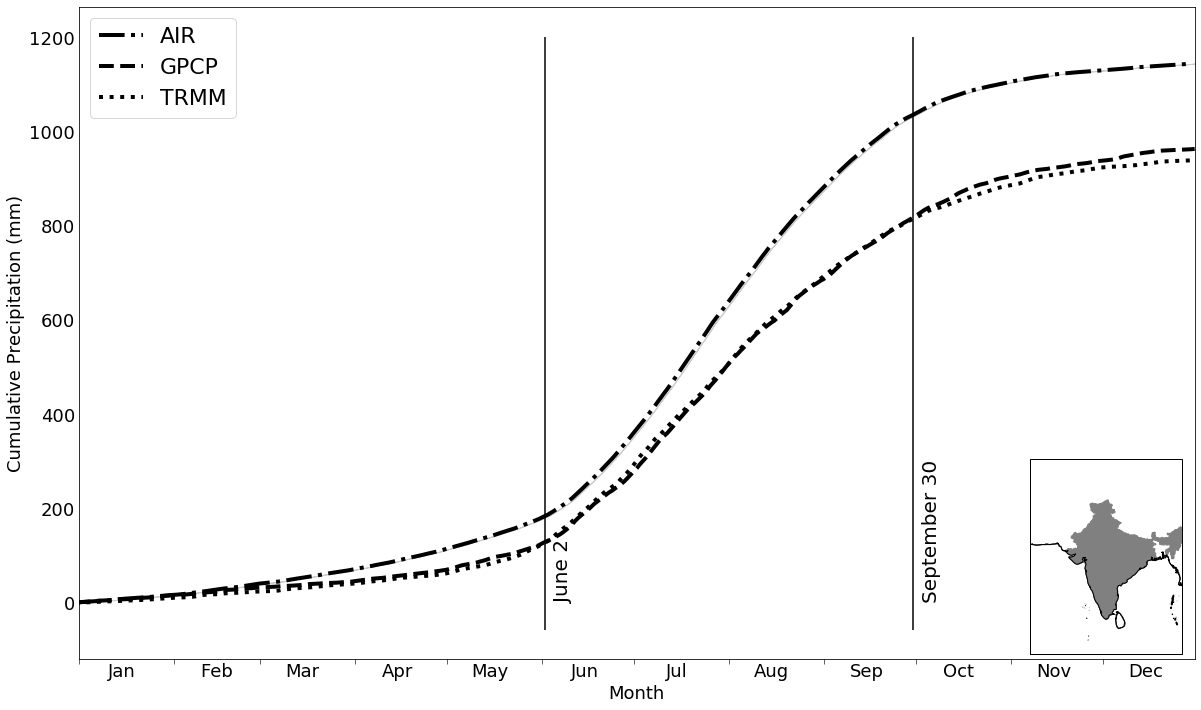

In [13]:
importlib.reload(myplt) # Required because I am constantly editing scam_func.py

fig, ax = mp.subplots(figsize=(20,12))
#ax = fig.add_axes([0.15,0.35,0.15,0.2],)
axins = myplt.region_mask(ax,lat_lon,lmask=True)

land_10m = NaturalEarthFeature('physical', 'land', '10m')
print(land_10m)

print(' ---------- Variable = '+var_name+' -----------')

for icase,cname in enumerate(case_names):
    
    nens = len(rset_df.loc[cname]['ens_rnums']) # Num. Ensmble simulations
    
    print('')
    print('**************************************************************')
    print('* Ensemble set #',icase+1,' (',cname,') - ',nens,' ensemble simulations')
    print('* Asking for years ',years[0],' to ',years[1])
    print('**************************************************************')
          
    rset = rset_df.loc[cname]   
    
        
    '''
        Routine for reading in data and calculating annual cycle from daily data
    '''
    
    %time var_data = myplt.calc_daily_acycle(reg_name,cname,rset_df,var_df) # rest dic and ens index   
    
    print(var_data)
    
    '''
        Line plotting 
    '''
    
    linecol = rset_df.loc[cname]['p_linecol']    
    ldash = rset_df.loc[cname]['p_ldash']    
    lthick = rset_df.loc[cname]['p_lthick']    
    porder = 5 if cname in var_df.loc[var_name]['osource'] else 1
    
    
   
    #%time for iens in range(0,nens) : ax.plot(var_data[iens,:],color=linecol,linestyle=ldash,linewidth=lthick,zorder=porder)
    %time for iens in range(0,nens) : ax.plot(var_data.mean(dim="ens_num"),color=linecol,linestyle=ldash,linewidth=lthick,zorder=porder)
    
    if cname not in ['TRMM','GPCP']:
        ax.fill_between(var_data.dayofyear, var_data.min(dim="ens_num"), var_data.max(dim="ens_num"), color=scolors[icase], alpha=.2)
    
    
'''
    Set Axes And Legend
'''

date_form = DateFormatter("%b")

ax.xaxis.set_major_locator(MonthLocator(bymonthday=15))
ax.xaxis.set_minor_locator(MonthLocator())
ax.xaxis.set_major_formatter(date_form)

ax.set_xlim([1,365]) 
yr = ax.get_ylim()
ax.vlines(153, yr[0], yr[1], color='black', linestyle='-') # Jun 2
ax.vlines(273, yr[0], yr[1], color='black', linestyle='-') # Spe 30

ax.text(156, 0, "June 2", rotation=90, verticalalignment='bottom',fontsize=20)
ax.text(276, 0, "September 30", rotation=90, verticalalignment='bottom',fontsize=20)

ax.tick_params(which='major', length=0)
ax.tick_params(which='minor', length=5)
ax.set_xlabel('Month', fontsize=18)
ax.set_ylabel('Cumulative Precipitation (mm)', fontsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)




ax.legend(leg_lines, case_names,loc='upper left',fontsize=22)
mp.savefig('daily_prec_as_AIR_cesm_e3sm_test.png', dpi=70)  
    